# Лабораторная работа №5

## Setup

In [7]:
import re
import nltk
import random

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
from transformers import BertTokenizer, BertForSequenceClassification, AdamW,  get_linear_schedule_with_warmup


import pandas as pd
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns


from tqdm.auto import tqdm


PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

RANDOM_SEED = 42


# Set the seed value all over the place to make this reproducible.
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Функция Обучения

In [3]:
def train(model, optimizer, criterion, n_epochs, train_loader, test_loader):

  loss_train = []
  accuracy_train = []

  for epoch in range(n_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{n_epochs}"):
        inputs = batch["input"]
        labels = batch["label"]
        output = model(inputs)

        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
      for batch in tqdm(test_loader, desc=f"Testing epoch {epoch + 1}/{n_epochs}"):
        inputs = batch["input"]
        labels = batch["label"]
        output = model(inputs)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    accuracy_train.append(test_accuracy)
    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
    loss_train.append(loss.item())


## Google Drive if need

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Задание 1. Изучите технологии attention и архитектуры нейронных сетей трансформеров.

In [4]:
###

## Задание 2. Примените один из трансформеров, например BERT к задаче классификации отзывов клиентов. Сравните полученные результаты с классическими методами машинного обучения, с RNN. Сделайте выводы.

### Dataset

In [9]:
df_reviews = pd.read_csv('/content/drive/MyDrive/NLP_FU/lem_500kdata.csv', index_col = 0)
df_reviews.dropna(inplace = True)
df_reviews

,rating,text
0,3,московский квартал шумно лето ночь дикий гонка...
1,5,замечательный сеть магазин общий хороший ассор...
2,1,знать смутить коготь дать правило удивить хоте...
3,4,хороший условие аренда дружелюбный персонално ...
4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...
499994,5,хороший способ избежать автобусный пытка элект...
499995,4,охрана кривая добрый дверь закрываться автомат...
499996,4,сравнение многий современный платформа эпоха с...
499998,5,семья отличный место рекомендовать это настоящ...


### Balance classes

In [10]:
min_class_size  = df_reviews['rating'].value_counts().min()

df_reviews['rating'].value_counts()

5    389674
4     41114
1     34297
3     21651
2     12071
Name: rating, dtype: int64

In [11]:
df_reviews = pd.concat([group.sample(min_class_size) for _, group in df_reviews.groupby('rating')])

In [12]:
df_reviews

,rating,text
105034,1,добрый день советовать внимательно ознакомитьс...
327506,1,приезжать оценка страховой начать назвать адре...
153404,1,вроде рынок прекрасный видимо закон рф продаве...
326023,1,комиссия оформление жд билет около стоимость с...
1598,1,компания оооэсардж удалить список оценщик банк...
...,...,...
480058,5,охарактеризовать парква который провести свой ...
238930,5,удобный расположение типография близко метро н...
206249,5,классный интерактивный минь музей замечательны...
388949,5,приятный доброжелательный людибыстрый обслужив...


### DeepPavlov tokenizer

In [13]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [14]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### class Dataset with tokenizer


In [18]:
class MyDataset(Dataset):

  def __init__(self, reviews, labels, tokenizer, max_len):
    self.reviews = reviews
    self.labels = labels - 1
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(labels, dtype=torch.long)
    }

In [19]:
# class MyDataset(Dataset):

#     def __init__(self, all_reviews, labels):
#         self.all_reviews = all_reviews
#         self.labels = labels

#     def __getitem__(self, ids):

#         return {
#             'input_ids' : self.all_reviews[ids]['input_ids'].squeeze().to(torch.long),
#             'token_type_ids' : self.all_reviews[ids]['token_type_ids'].squeeze().to(torch.long),
#             'attention_mask' : self.all_reviews[ids]['attention_mask'].squeeze().to(torch.long),
#             'labels' : torch.tensor(self.labels.values[ids], dtype=torch.long)
#         }

#     def __len__(self):
#         return len(self.all_reviews)

### Test and Train

In [20]:
df_train, df_test = train_test_split(df_reviews, test_size=0.25, random_state=RANDOM_SEED)

### DataLoader

In [21]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MyDataset(
    reviews=df['text'].to_numpy(),
    labels=df['rating'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
  )

In [22]:
BATCH_SIZE = 64
MAX_LEN = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [19]:
data = next(iter(train_data_loader))
data

{'review_text': ['очень информативный палезный тренинг большой спасибо',
  'ужастной просто обслуживание регистратура это вообще ужас просто взять талончик просить час подождать пока сотрудник регистратура поболтать себя услыш идти любой кабинет очередь продезь нужный ты врач непонятный вообще система человек записываться врач должный слово сотрудник регистратура влезть очередь просто ужас поход просто закрыть больничный превращаться час потерянный жизнь',
  'самый дорогой аптека сравнивать стоимость лекарство другой аптека город сам аптека прибор экстренный измерение артериальный давление практически другой аптека город очень плохой ассортимент лекарство заходить раз раз нужный лекарство самый главное этот аптека единственный весь микрорайон очень жалко аптека именно сеть оказаться данный место',
  'домик озерапрекрасный место отдых весь семьикомфортабельный домик весь удобствамичистый воздуххорошать рыбалкадоброжелательный обслуживающий персоналотзывчивый хозяин александрряд магазин 

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64])


### DeepPavlov Model

In [21]:
bert_model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Предупреждение, что мы должны обучить модель на свои данных

### Sample Review

In [22]:
test_bert_model = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
sample_txt = "мне не понравилась еда"

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=64,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

encoding

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[  101, 16740,  1699, 57854, 83087,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'мне',
 'не',
 'понравилась',
 'еда',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [25]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([1, 64])
torch.Size([1, 64])


In [26]:
test_bert_model(input_ids, attention_mask)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0866, -0.1025,  0.2493,  0.0689, -0.0319]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Train

In [27]:
EPOCHS = 10

optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
loss_train = []
accuracy_train = []


for epoch in range(EPOCHS):


    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)

    bert_model.train()
    for batch in tqdm(train_data_loader, desc=f"Training epoch {epoch + 1}/{EPOCHS}"):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)



      # Always clear any previously calculated gradients before performing a
      # backward pass. PyTorch doesn't do this automatically because
      # accumulating the gradients is "convenient while training RNNs".
      # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
      bert_mode.zero_grad()


      # Perform a forward pass (evaluate the model on this training batch).
      # The documentation for this `model` function is here:
      # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
      # It returns different numbers of parameters depending on what arguments
      # are given and what flags are set. For our usage here, it returns
      # the loss (because we provided labels) and the "logits"--the model
      # outputs prior to activation.
      outputs = bert_model(input_ids,
                             token_type_ids=None,
                             attention_mask=attention_mask,
                             labels=labels)
      loss = outputs.loss
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      nn.utils.clip_grad_norm_(bert_model.parameters(), max_norm=1.0)
      optimizer.step()

      # Update the learning rate.
      scheduler.step()
      optimizer.zero_grad()

    bert_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_data_loader, desc=f"Testing epoch {epoch + 1}/{EPOCHS}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = bert_model(input_ids,
                             token_type_ids=None,
                             attention_mask=attention_mask
                                 )

            logits = outputs.logits
            predicted = torch.argmax(logits, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()



            # # Accumulate the validation loss.
            # total_eval_loss += loss.item()

            # # Move logits and labels to CPU
            # logits = logits.detach().cpu().numpy()
            # label_ids = b_labels.to('cpu').numpy()

            # # Calculate the accuracy for this batch of test sentences, and
            # # accumulate it over all batches.
            # total_eval_accuracy += flat_accuracy(logits, label_ids)



    test_accuracy = correct / total
    accuracy_train.append(test_accuracy)
    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch + 1, EPOCHS, loss.item(), test_accuracy * 100))
    loss_train.append(loss.item())


Training epoch 1/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 1/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.2447, Test Accuracy: 54.09%


Training epoch 2/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 2/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.7332, Test Accuracy: 54.97%


Training epoch 3/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 3/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.6839, Test Accuracy: 53.45%


Training epoch 4/10:   0%|          | 0/708 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7825996ecaf0><function _MultiProcessingDataLoaderIter.__del__ at 0x7825996ecaf0>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Testing epoch 4/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.5636, Test Accuracy: 53.48%


Training epoch 5/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 5/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.8819, Test Accuracy: 51.42%


Training epoch 6/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 6/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.1685, Test Accuracy: 51.57%


Training epoch 7/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 7/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.2824, Test Accuracy: 51.70%


Training epoch 8/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 8/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.3355, Test Accuracy: 51.64%


Training epoch 9/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 9/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0674, Test Accuracy: 51.50%


Training epoch 10/10:   0%|          | 0/708 [00:00<?, ?it/s]

Testing epoch 10/10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0126, Test Accuracy: 51.88%


### Save my model

In [32]:
bert_model.save_pretrained('/content/drive/MyDrive/NLP_FU/bertreviews24dec')

### Load my model

In [5]:
bert_model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP_FU/bertreviews24dec").to(device)

### Matrix Confusion

  0%|          | 0/236 [00:00<?, ?it/s]

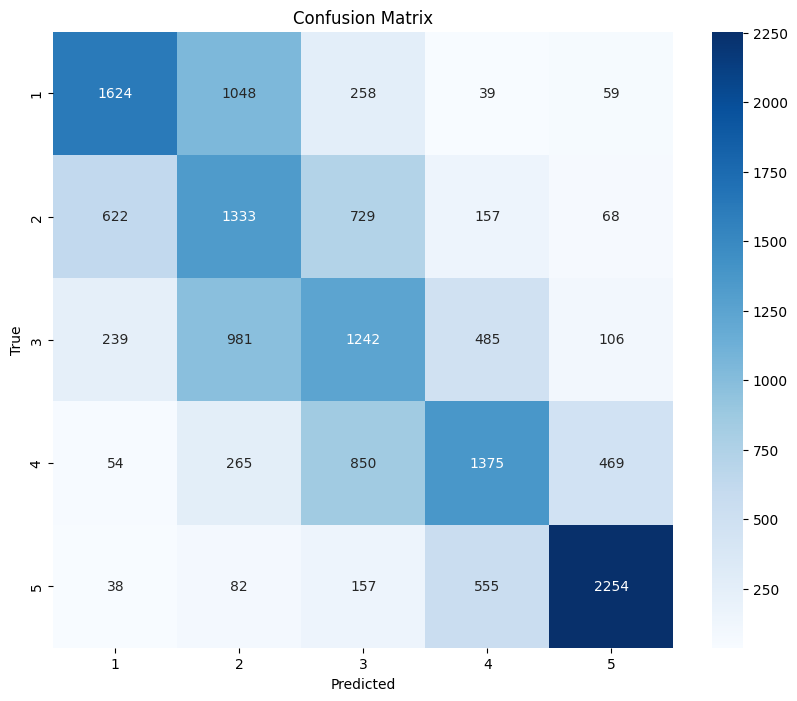

In [25]:
bert_model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in tqdm(test_data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = bert_model(input_ids,
                          token_type_ids=None,
                          attention_mask=attention_mask)

        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)





        # Move logits and labels to CPU
        predicted = predicted.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        predicted_labels.extend(predicted + 1)
        true_labels.extend(labels + 1)


        # # Calculate the accuracy for this batch of test sentences, and
        # # accumulate it over all batches.
        # total_eval_accuracy += flat_accuracy(logits, label_ids)

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Online check

In [46]:
batch["input_ids"].shape, batch["attention_mask"].shape


(torch.Size([49, 64]), torch.Size([49, 64]))

In [48]:
batch["input_ids"], batch["attention_mask"]


(tensor([[  101,  7805, 36613,  ...,   874,  3231,   102],
         [  101, 40841, 20953,  ...,     0,     0,     0],
         [  101,  7478,  1468,  ..., 55435,  5781,   102],
         ...,
         [  101,  8470, 44390,  ..., 34699, 53182,   102],
         [  101,  3998, 25596,  ..., 38636,  1714,   102],
         [  101, 70088,  3439,  ..., 27946,   102,     0]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 0]]))

In [26]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence", do_lower_case=True)

In [34]:
def encode(review):
    encoding = tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=64,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
    }

In [67]:
bert_model.eval()
str_review = "мне понравился ресторант, вкусная еда и приятная атмосфера"
review = encode(str_review)
with torch.no_grad():
        input_ids = review["input_ids"].unsqueeze(0).to(device)
        attention_mask = review["attention_mask"].unsqueeze(0).to(device)



        outputs = bert_model(input_ids,
                          token_type_ids=None,
                          attention_mask=attention_mask)



        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1)
        print(f"Review {str_review} is  {predicted[0]}")

Review мне понравился ресторант, вкусная еда и приятная атмосфера is  4


### Summary

Есть над чем работать, rnn показал себя гораздо лучше 91.30%. По матрице мне нравится, что он угадывает все отзывы и нет такого, что только 1 и 5. НУжно еще поработать.

## Задание 3. Примените один из трансформеров, например BERT, к задаче генерации англоязычного и русскоязычного текстов. Сравните результаты с LSTM. Сделайте выводы.

## Задание 4. Примените один из трансформеров, например BERT, к задаче машинного перевода.

## Cool tips

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 66

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))